In [1]:
import numpy as np
import os
import re
import pydicom
import cv2
import random
import imageio
import scipy.ndimage
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from PIL import Image
from models import resnet
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPool3D
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

print(torch.cuda.is_available())
print('Import Scussessful!')

True
Import Scussessful!


In [8]:
X = np.load('./data/X3.npy')
y= np.load('./data/y3.npy')
X = X.transpose((0, 4, 1, 2, 3))
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.6 * len(dataset)) 
val_size = int(0.2 * len(dataset))  
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print('Data Splitting Successful!')

Data Splitting Successful!


In [ ]:
# Pretrained Model Source: Med3D
@article{chen2019med3d,
    title={Med3D: Transfer Learning for 3D Medical Image Analysis},
    author={Chen, Sihong and Ma, Kai and Zheng, Yefeng},
    journal={arXiv preprint arXiv:1904.00625},
    year={2019}
}

In [9]:
def generate_model(model_type='resnet', model_depth=50,
                   input_W=224, input_H=224, input_D=224, resnet_shortcut='B',
                   no_cuda=False, gpu_id=[0],
                   pretrain_path = 'pretrain/resnet_50.pth',
                   nb_class=1):
    assert model_type in [
        'resnet'
    ]
    if model_type == 'resnet':
        assert model_depth in [10, 18, 34, 50]
    if model_depth == 10:
        model = resnet.resnet10(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 256
    elif model_depth == 18:
        model = resnet.resnet18(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 512
    elif model_depth == 34:
        model = resnet.resnet34(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 512
    elif model_depth == 50:
        model = resnet.resnet50(
            sample_input_W=input_W,
            sample_input_H=input_H,
            sample_input_D=input_D,
            shortcut_type=resnet_shortcut,
            no_cuda=no_cuda,
            num_seg_classes=1)
        fc_input = 2048
    hidden_units1 = 256
    hidden_units2 = 128
    model.conv_seg = nn.Sequential(
        nn.AdaptiveAvgPool3d((1, 1, 1)),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(in_features=fc_input, out_features=hidden_units1),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units2, out_features=nb_class, bias=True)
    )
    if not no_cuda:
        if len(gpu_id) > 1:
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=gpu_id)
            net_dict = model.state_dict()
        else:
            import os
            os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id[0])
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=None)
            net_dict = model.state_dict()
    else:
        net_dict = model.state_dict()
    print('loading pretrained model {}'.format(pretrain_path))
    pretrain = torch.load(pretrain_path)
    pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
    net_dict.update(pretrain_dict) 
    model.load_state_dict(net_dict)
    print("-------- pre-train model load successfully --------")
    return model

model = generate_model(model_type='resnet', model_depth=50,
                   input_W=100, input_H=80, input_D=20, resnet_shortcut='B',
                   no_cuda=False, gpu_id=[0],
                   pretrain_path='./pretrained/resnet_50_23dataset.pth',
                   nb_class=4)

loading pretrained model ./pretrained/resnet_50_23dataset.pth
-------- pre-train model load successfully --------


In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        target_indices = torch.argmax(target, dim=1)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target_indices)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
    train_accuracies.append(100 * correct / total)
    train_losses.append(train_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader:
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            target_indices = torch.argmax(target, dim=1)
            outputs = model(data)
            loss = criterion(outputs, target_indices)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target_indices).sum().item()
    val_accuracies.append(100 * val_correct / val_total)
    val_losses.append(val_loss/len(val_loader))
    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * val_correct / val_total}%")

Epoch 1/100, Train Loss: 1.363086261768115, Accuracy: 32.739861523244315%
Validation Loss: 1.3653408345054179, Accuracy: 30.56379821958457%
Epoch 2/100, Train Loss: 1.3493572831625054, Accuracy: 34.56973293768546%
Validation Loss: 1.3229134054744944, Accuracy: 37.982195845697326%
Epoch 3/100, Train Loss: 1.338371183090059, Accuracy: 33.333333333333336%
Validation Loss: 1.3489556172314812, Accuracy: 32.195845697329375%
Epoch 4/100, Train Loss: 1.3226998266966448, Accuracy: 35.954500494559845%
Validation Loss: 1.3437238735311172, Accuracy: 31.602373887240358%
Epoch 5/100, Train Loss: 1.314924501147666, Accuracy: 35.361028684470824%
Validation Loss: 1.3222222819047815, Accuracy: 30.86053412462908%
Epoch 6/100, Train Loss: 1.307299420767622, Accuracy: 36.39960435212661%
Validation Loss: 1.302661773737739, Accuracy: 35.60830860534124%
Epoch 7/100, Train Loss: 1.292756930641506, Accuracy: 37.63600395647873%
Validation Loss: 1.283827213680043, Accuracy: 35.311572700296736%
Epoch 8/100, Train 

Validation Loss: 0.36083625665975405, Accuracy: 90.35608308605342%
Epoch 60/100, Train Loss: 0.12170697734626783, Accuracy: 95.64787339268051%
Validation Loss: 0.29432786600938177, Accuracy: 92.7299703264095%
Epoch 61/100, Train Loss: 0.06210663299335778, Accuracy: 98.07121661721068%
Validation Loss: 0.32851189220639165, Accuracy: 92.43323442136499%
Epoch 62/100, Train Loss: 0.04585144686601916, Accuracy: 98.66468842729971%
Validation Loss: 0.3378559541775544, Accuracy: 91.24629080118694%
Epoch 63/100, Train Loss: 0.04520676533572869, Accuracy: 98.56577645895153%
Validation Loss: 0.3347542399246081, Accuracy: 91.3946587537092%
Epoch 64/100, Train Loss: 0.11634696896966518, Accuracy: 96.53808110781405%
Validation Loss: 0.34772304333198595, Accuracy: 91.54302670623146%
Epoch 65/100, Train Loss: 0.10664921341346127, Accuracy: 96.3402571711177%
Validation Loss: 0.30917330657351105, Accuracy: 92.43323442136499%
Epoch 66/100, Train Loss: 0.0563502836125358, Accuracy: 98.02176063303659%
Valid

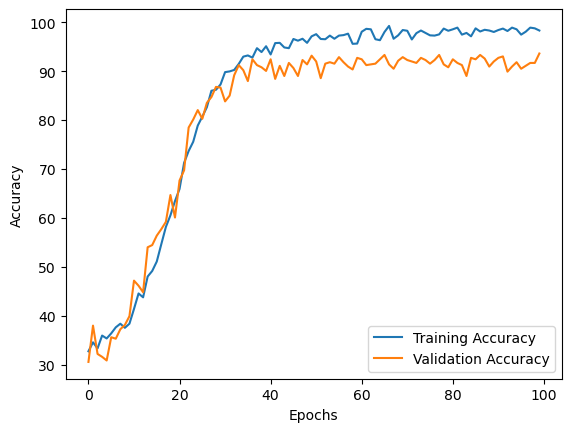

In [12]:
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

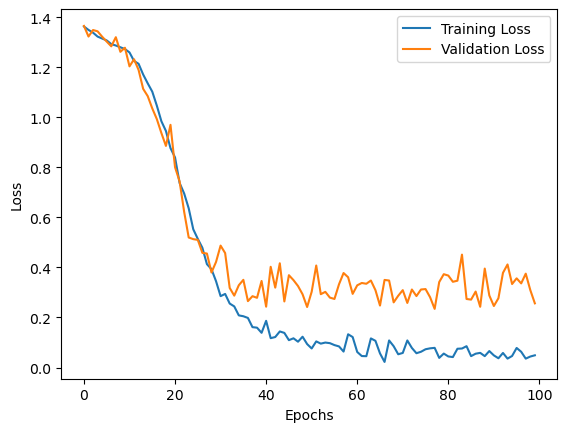

In [13]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 89.46587537091987%
Confusion Matrix:
[[171   7   5   5]
 [  3 152  12   5]
 [  2   5 142   3]
 [  6   5  13 138]]
Precision: 0.8946143509252893
Recall: 0.8948394441213265


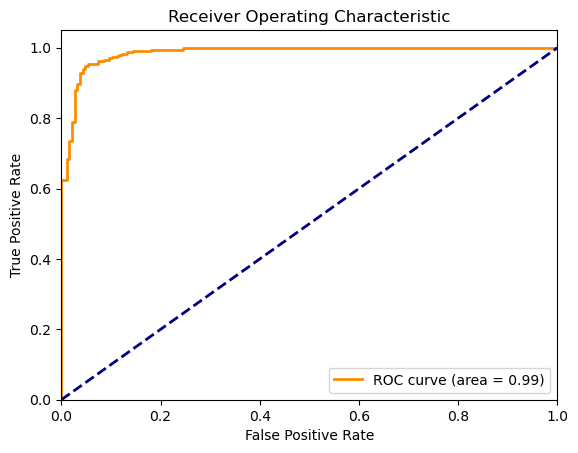

In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader: 
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        target_indices = torch.argmax(target, dim=1)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")



all_targets = []
all_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        target_indices = torch.argmax(target, dim=1)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        all_targets.extend(target_indices.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
conf_mat = confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(conf_mat)
precision = precision_score(all_targets, all_predictions, average='macro')
print(f"Precision: {precision}")
recall = recall_score(all_targets, all_predictions, average='macro')
print(f"Recall: {recall}")
all_scores = []
all_targets_binary = []
with torch.no_grad():
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        outputs = model(data)
        scores = outputs[:, 1:].max(dim=1).values.cpu().numpy() 
        target_indices = torch.argmax(target, dim=1)
        binary_targets = (target_indices != 0).cpu().numpy()
        all_scores.extend(scores)
        all_targets_binary.extend(binary_targets)
fpr, tpr, _ = roc_curve(all_targets_binary, all_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
actual_model = model.module
torch.save(actual_model.state_dict(), 'final_pretrained.pt')